In [1]:
import os
executable_path = "/home/alberto/.sdkman/candidates/java/current/bin"
if executable_path not in os.environ["PATH"]:
    os.environ["PATH"] = f"{executable_path}:{os.environ['PATH']}"

from scipy.signal import cont2discrete, lti, dstep
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Ra = 5 # Armature resistance [Ohm]
La = 10e-3 # Winding inductance [Henry]
Kb = 0.1 # Motor's back EMF constant 
B = 0.05 # Damping in the motor load
J = 0.01 # Motor inertia [Kg m^2]
Ktau = 5 # Torque constant that relates to the armature current

In [3]:
ss_A = np.array([
    [-Ra/La, 0, -Kb/La],
    [0, 0, 1],
    [Ktau, 0, -B/J]
])
ss_B = np.array([[1/La, 0, 0]]).T
ss_C = np.array([0, 1, 0])
ss_D = 0

dt = 0.1

l_system = lti(ss_A, ss_B, ss_C, ss_D)
d_system = cont2discrete((ss_A, ss_B, ss_C, ss_D), dt, method="zoh")

In [4]:
ss_A, np.linalg.eig(ss_A)

(array([[-500.,    0.,  -10.],
        [   0.,    0.,    1.],
        [   5.,    0.,   -5.]]),
 EigResult(eigenvalues=array([   0.        , -499.89896928,   -5.10103072]), eigenvectors=array([[ 0.00000000e+00, -9.99948968e-01,  1.98248186e-02],
        [ 1.00000000e+00, -2.02091967e-05,  1.92339212e-01],
        [ 0.00000000e+00,  1.01025566e-02, -9.81128230e-01]])))

Two eigenvalues are unstable, so it makes sense to try to stabilize the system.

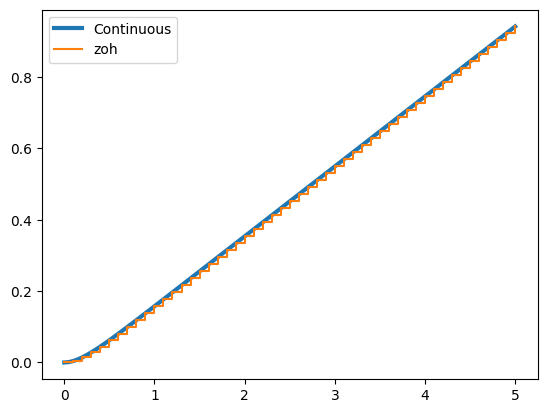

In [5]:
t, x = l_system.step(T=np.linspace(0, 5, 100))

fig, ax = plt.subplots()
ax.plot(t, x, label='Continuous', linewidth=3)


s, x_d = dstep(d_system, t=t)
ax.step(s, np.squeeze(x_d), label="zoh", where='post')

ax.legend(loc='best')
plt.show()

In [6]:
def pid(error, previous_error, parameters):
    Kp, Ki, Kd = parameters

    tension = Kp * error + Ki * (error + previous_error) + Kd * (error - previous_error)

    return tension

In [7]:
X0 = np.array([[0,0,0]]).T
Ys = []

TIME_STEPS = 1000

NO_OVERSHOOT_SLOW = (0.02, 0.03, 0.2)
QUICK_NO_OVERSHOOT = (1, 0.03, 0.2)
RESONANCE = (100, 0.03, 0.2)

for parameters in [NO_OVERSHOOT_SLOW, QUICK_NO_OVERSHOOT, RESONANCE]:
    x = X0
    y = np.array([0])
    u = np.array([0])
    p_err = np.array([0])

    Y = []

    for t in range(TIME_STEPS):
        # Calculate the system output
        y = d_system[2] @ x
        Y.append(y)

        # Compute the error
        error = np.pi - y

        # Use the PID to find the new input
        u = pid(error, p_err, parameters)
        p_err = error

        # Compute the new state
        x = d_system[0] @ x + d_system[1] @ u.reshape(1,1)

    Y = np.array(Y)
    Y = Y.reshape(Y.shape[0])
    Ys.append(Y)

targetSignal = [np.pi for i in range(len(Ys[0]))]
time = np.linspace(0,TIME_STEPS*0.1,num=len(Y))

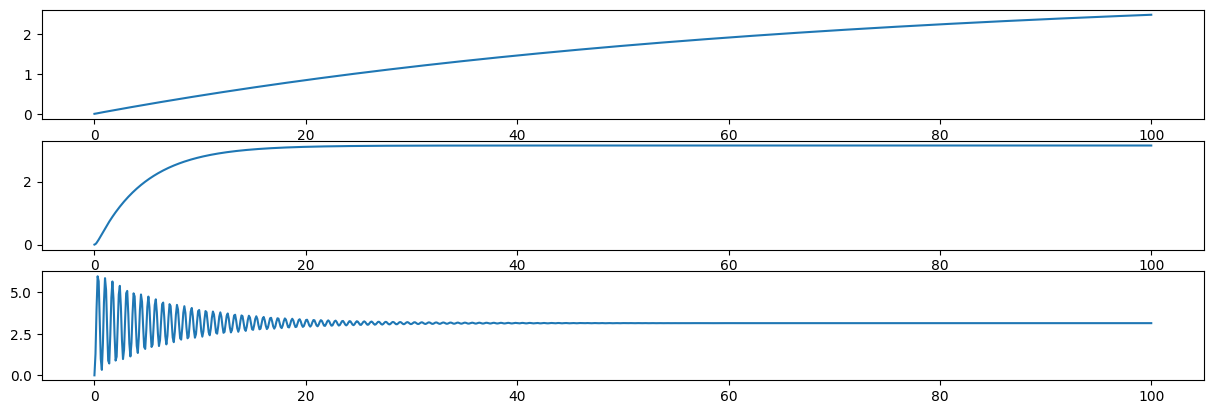

In [8]:
plt.figure(figsize=(15, 15))

for i in range(len(Ys)):
    plt.subplot(9, 1, i+1)
    plt.plot(time, Ys[i])

# Requirements that a controller should satisfy

1. No overshoot
2. Should settle down within 20s
3. Should not have resonance

In [9]:
import moonlight
from string import Template

In [10]:
SETTLE_DOWN_TIME = 20 # s
MAX_TIME = TIME_STEPS * 0.1 - 1 # s
OVERSHOOT_TOLLERANCE = 10 * (np.pi/180) # rad
RESONANCE_TRESHOLD = 1

In [11]:
# Oscillation: G(high→Flow)∧G(low→Fhigh).

# & (TooLow => eventually {{ TooHigh }})
# globally {{ TooLow -> eventually {{ TooHigh }} }} & globally {{ TooHigh -> eventually {{ TooLow }} }}
# formula MonSettleDown = eventually [{SETTLE_DOWN_TIME + 9}, {SETTLE_DOWN_TIME + 10}] WithinBounds;

script = f"""
signal {{ real x; real y; }}
domain boolean;

formula Overshoot = abs(x - y) > {OVERSHOOT_TOLLERANCE};
formula MonOvershoot = eventually [{SETTLE_DOWN_TIME}, {MAX_TIME}] {{ Overshoot }};

formula SettledDown = abs(x - y) < {OVERSHOOT_TOLLERANCE};
formula MonSettleDown = globally [{SETTLE_DOWN_TIME}, {MAX_TIME}] {{ SettledDown }};

formula TooHigh = (x - y) > {RESONANCE_TRESHOLD};
formula TooLow = (x - y) < -{RESONANCE_TRESHOLD};
formula ResonanceLowHigh = TooLow & eventually {{ TooHigh }};
formula ResonanceHighLow = TooHigh & eventually {{ TooLow }};
formula MonResonance = eventually {{ ResonanceLowHigh | ResonanceHighLow }};
"""

moonlightScript = moonlight.ScriptLoader.loadFromText(script)

In [12]:
def is_test_passed(results):
    overshoot = results[1][0][1]
    settledown = results[3][0][1]
    resonance = results[8][0][1]
    return overshoot == -1 and settledown == 1 and resonance == -1

JavaException: JVM exception occurred: Monitor Overshoot is unknown. java.lang.IllegalArgumentException

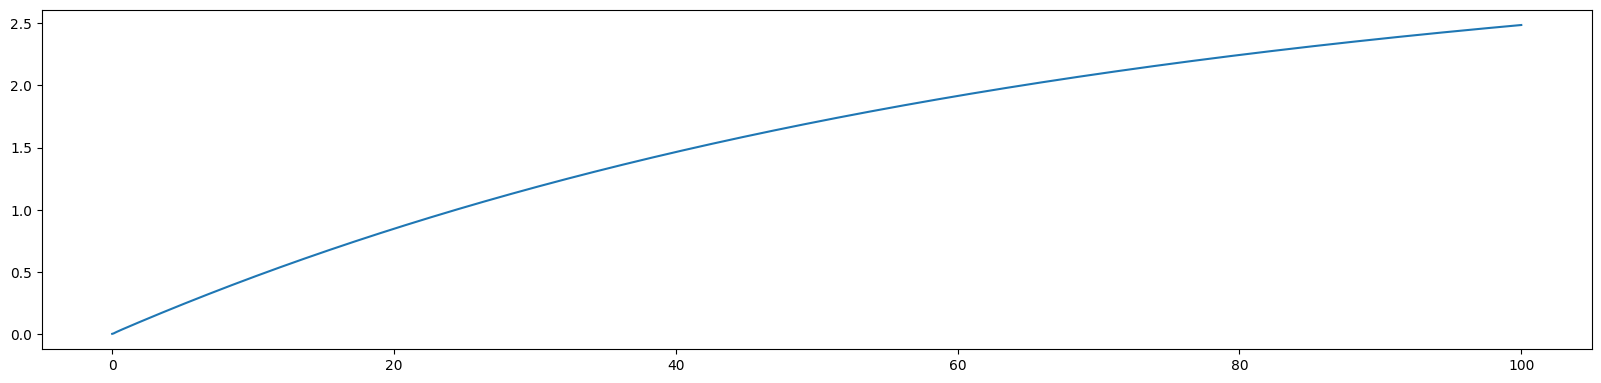

In [91]:
## STEP 4: getting the monitor associated with a target formula
MONITOR_NAMES = ["Overshoot", "MonOvershoot", "SettledDown", "MonSettleDown", "TooHigh", "TooLow", "ResonanceLowHigh", "ResonanceHighLow", "MonResonance"]
MONITOR_NAMES_TO_PLOT = ["MonOvershoot", "MonSettleDown", "MonResonance"]

plt.rcParams["figure.figsize"] = (20,15)
for i in range(len(Ys)):
    plt.subplot(3, 1, i+1)

    plt.plot(time, Ys[i], label = 'Signal')

    signals = list(zip(Ys[i], targetSignal))
    monitors = []
    results = []
    for m in MONITOR_NAMES:
        monitor = moonlightScript.getMonitor(m)
        monitors.append(monitor)
        result = np.array(monitor.monitor(list(time),signals))
        results.append(result)

    for j in range(len(results)):
        if MONITOR_NAMES[j] not in MONITOR_NAMES_TO_PLOT:
            continue
        r = results[j]
        plt.step(r[:,0],r[:,1], where='post', label=MONITOR_NAMES[j])
    
    print(i, "Test passed" if is_test_passed(results) else "Test not passed")


    plt.title("Plot of Monitor")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.legend()


# Tests with different noise

Let's increase the noise until the results are going to be faked

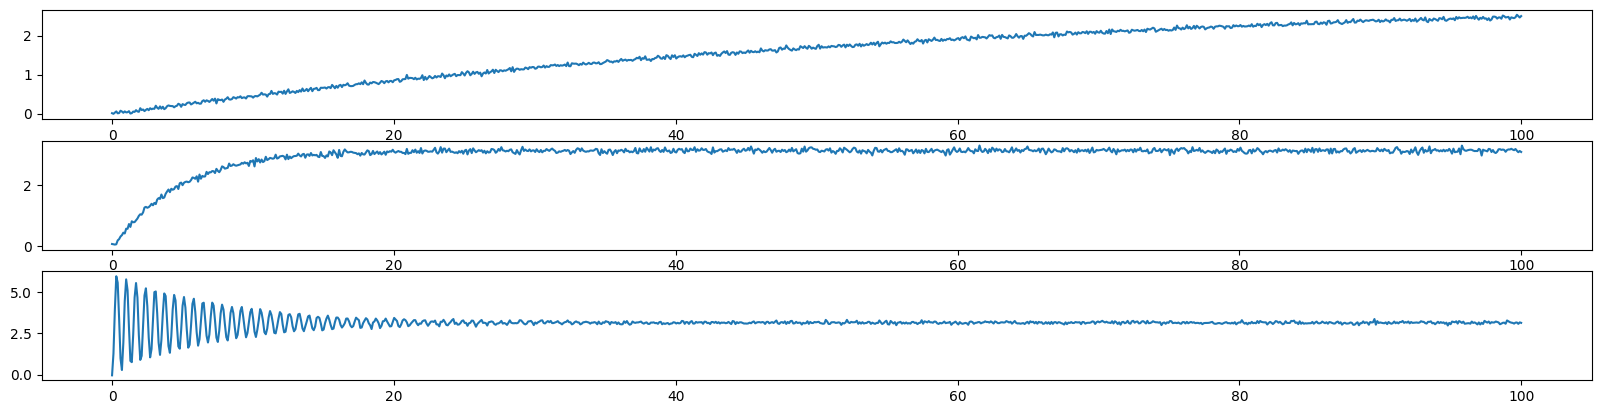

In [18]:
plt.figure(figsize=(20, 15))

SNR = 35 # dB
np.random.seed(42)

# Noise model
def add_noise_with_snr(signal, snr_db):
    # Calculate signal power
    signal_power = np.mean(signal ** 2)
    # Convert SNR from dB to linear scale
    snr_linear = 10 ** (snr_db / 10)
    # Calculate noise power
    noise_power = signal_power / snr_linear
    # Generate Gaussian noise with the calculated power
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    # Add noise to the signal
    noisy_signal = signal + noise
    
    return noisy_signal

Ys_noisy = [add_noise_with_snr(Ys[i], SNR) for i in range(len(Ys))]

for i in range(len(Ys)):
    plt.subplot(9, 1, i+1)
    plt.plot(time, Ys_noisy[i])

0 Test not passed
1 Test passed
2 Test not passed


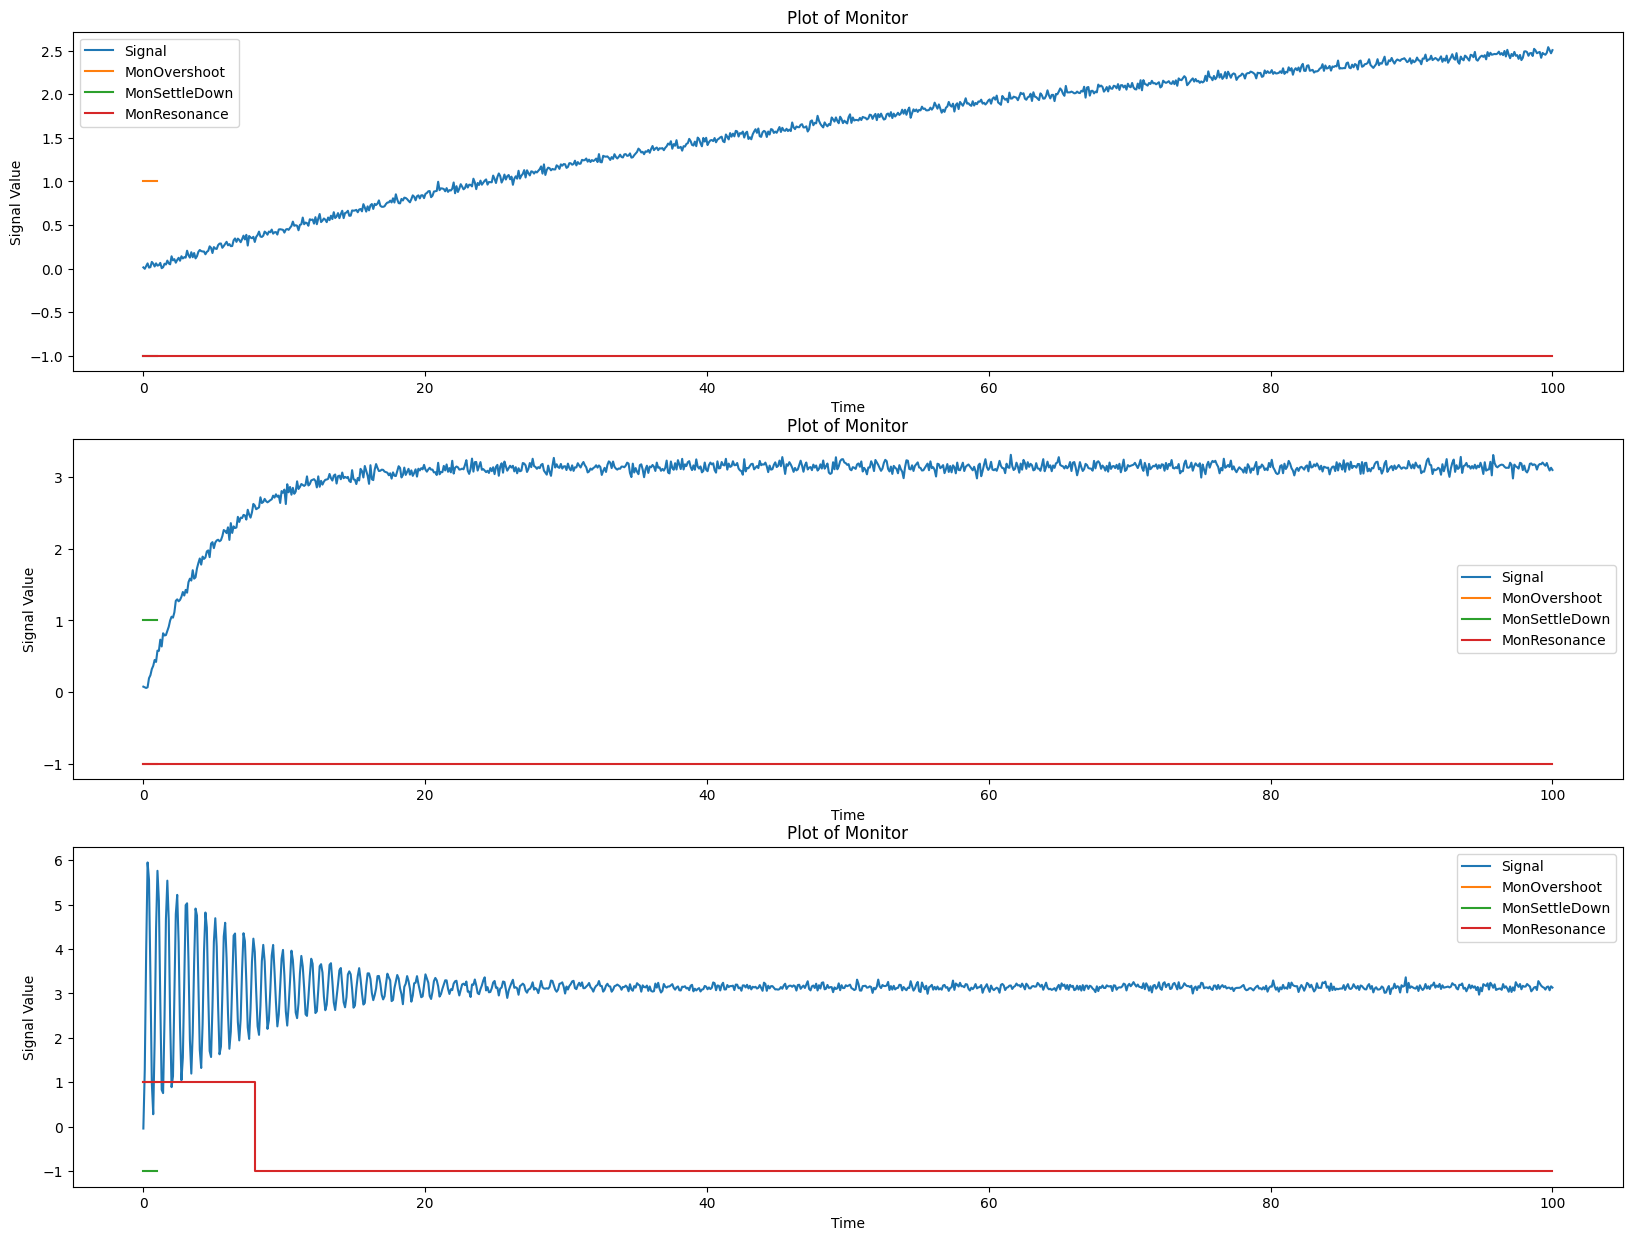

In [19]:
MONITOR_NAMES = ["Overshoot", "MonOvershoot", 
                 "SettledDown", "MonSettleDown",
                 "TooHigh", "TooLow", "ResonanceLowHigh", "ResonanceHighLow", "MonResonance"]
MONITOR_NAMES_TO_PLOT = ["MonOvershoot", "MonSettleDown", "MonResonance"]

plt.rcParams["figure.figsize"] = (20,15)

for i in range(len(Ys)):
    plt.subplot(3, 1, i+1)

    plt.plot(time, Ys_noisy[i], label = 'Signal')

    signals = list(zip(Ys_noisy[i], targetSignal))
    monitors = []
    results = []
    for m in MONITOR_NAMES:
        monitor = moonlightScript.getMonitor(m)
        monitors.append(monitor)
        result = np.array(monitor.monitor(list(time),signals))
        results.append(result)

    for j in range(len(results)):
        if MONITOR_NAMES[j] not in MONITOR_NAMES_TO_PLOT:
            continue
        r = results[j]
        plt.step(r[:,0],r[:,1], where='post', label=MONITOR_NAMES[j])
    
    print(i, "Test passed" if is_test_passed(results) else "Test not passed")

    plt.title("Plot of Monitor")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.legend()

# Further tests

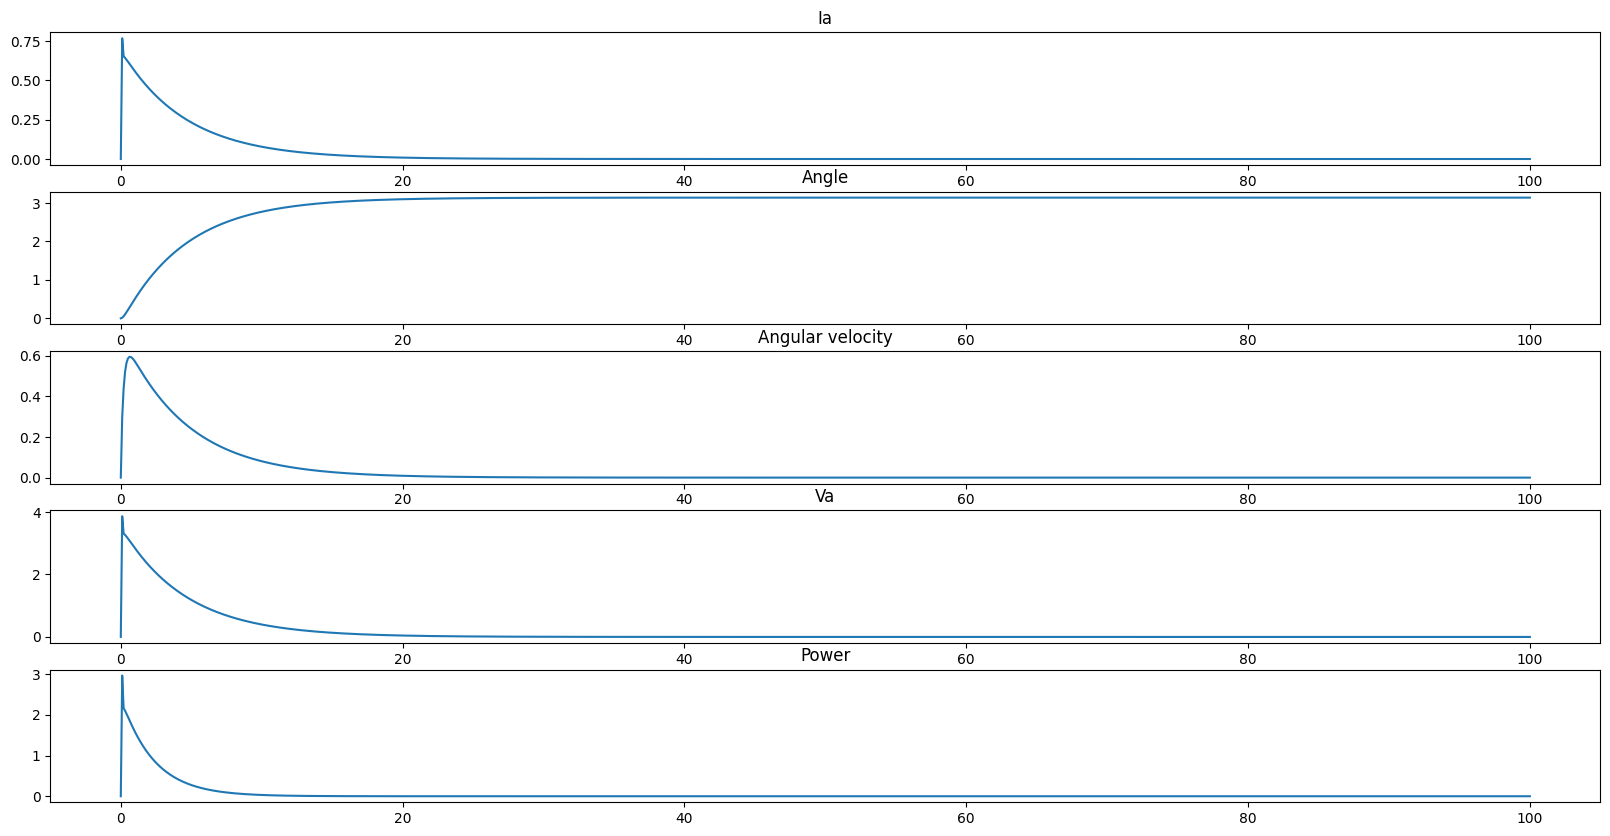

In [72]:
X0 = np.array([[0,0,0]]).T

TIME_STEPS = 1000

QUICK_NO_OVERSHOOT = (1, 0.03, 0.2)

parameters = QUICK_NO_OVERSHOOT

x = X0
y = np.array([0])
u = np.array([0])
p_err = np.array([0])

Y = []
X = []
U = []

for t in range(TIME_STEPS):
    # Calculate the system output
    y = d_system[2] @ x
    Y.append(y)

    # Compute the error
    error = np.pi - y

    # Use the PID to find the new input
    U.append(u)
    u = pid(error, p_err, parameters)
    p_err = error

    # Compute the new state
    X.append(x)
    x = d_system[0] @ x + d_system[1] @ u.reshape(1,1)

Y = np.array(Y)
Y = Y.reshape(Y.shape[0])

X = np.array(X)
U = np.array(U)

P = [U[i, 0] * X[i, 0] for i in range(len(X[:, 0]))]
P = np.array(P).reshape((len(P),1))

targetSignal = [np.pi for i in range(len(Ys[0]))]
time = np.linspace(0,TIME_STEPS*0.1,num=len(Y))

plt.rcParams["figure.figsize"] = (20,10)
ax = plt.subplot(5,1,1)
ax.set_title("Ia")
plt.plot(time, X[:, 0])

ax = plt.subplot(5,1,2)
ax.set_title("Angle")
plt.plot(time, X[:, 1])

ax = plt.subplot(5,1,3)
ax.set_title("Angular velocity")
plt.plot(time, X[:, 2])

ax = plt.subplot(5,1,4)
ax.set_title("Va")
plt.plot(time, U[:, 0])

ax = plt.subplot(5,1,5)
ax.set_title("Power")
plt.plot(time, P[:, 0])

Tests to be performed:
- Angle always below 180 degrees
- Maximum power consumption
- Speed and acceleration limits

In [113]:
MAX_ANGLE = 3.15
MAX_POWER = 5
MAX_ANGULAR_VELOCITY = 1

script = f"""
signal {{ real Ia; real Angle; real AngularVelocity; real Va; real Power; }}
domain boolean;

formula MonAngle = globally {{ Angle < {MAX_ANGLE} }};

formula MonPower = globally {{ Power < {MAX_POWER} }};

formula MonAngularVelocity = globally {{ AngularVelocity < {MAX_ANGULAR_VELOCITY} }};
"""

moonlightScript = moonlight.ScriptLoader.loadFromText(script)

In [114]:
def is_test_passed(results):
    angle = results[0][0][1]
    power = results[1][0][1]
    angularVelocity = results[2][0][1]

    return angle == 1 and power == 1 and angularVelocity == 1

Test passed


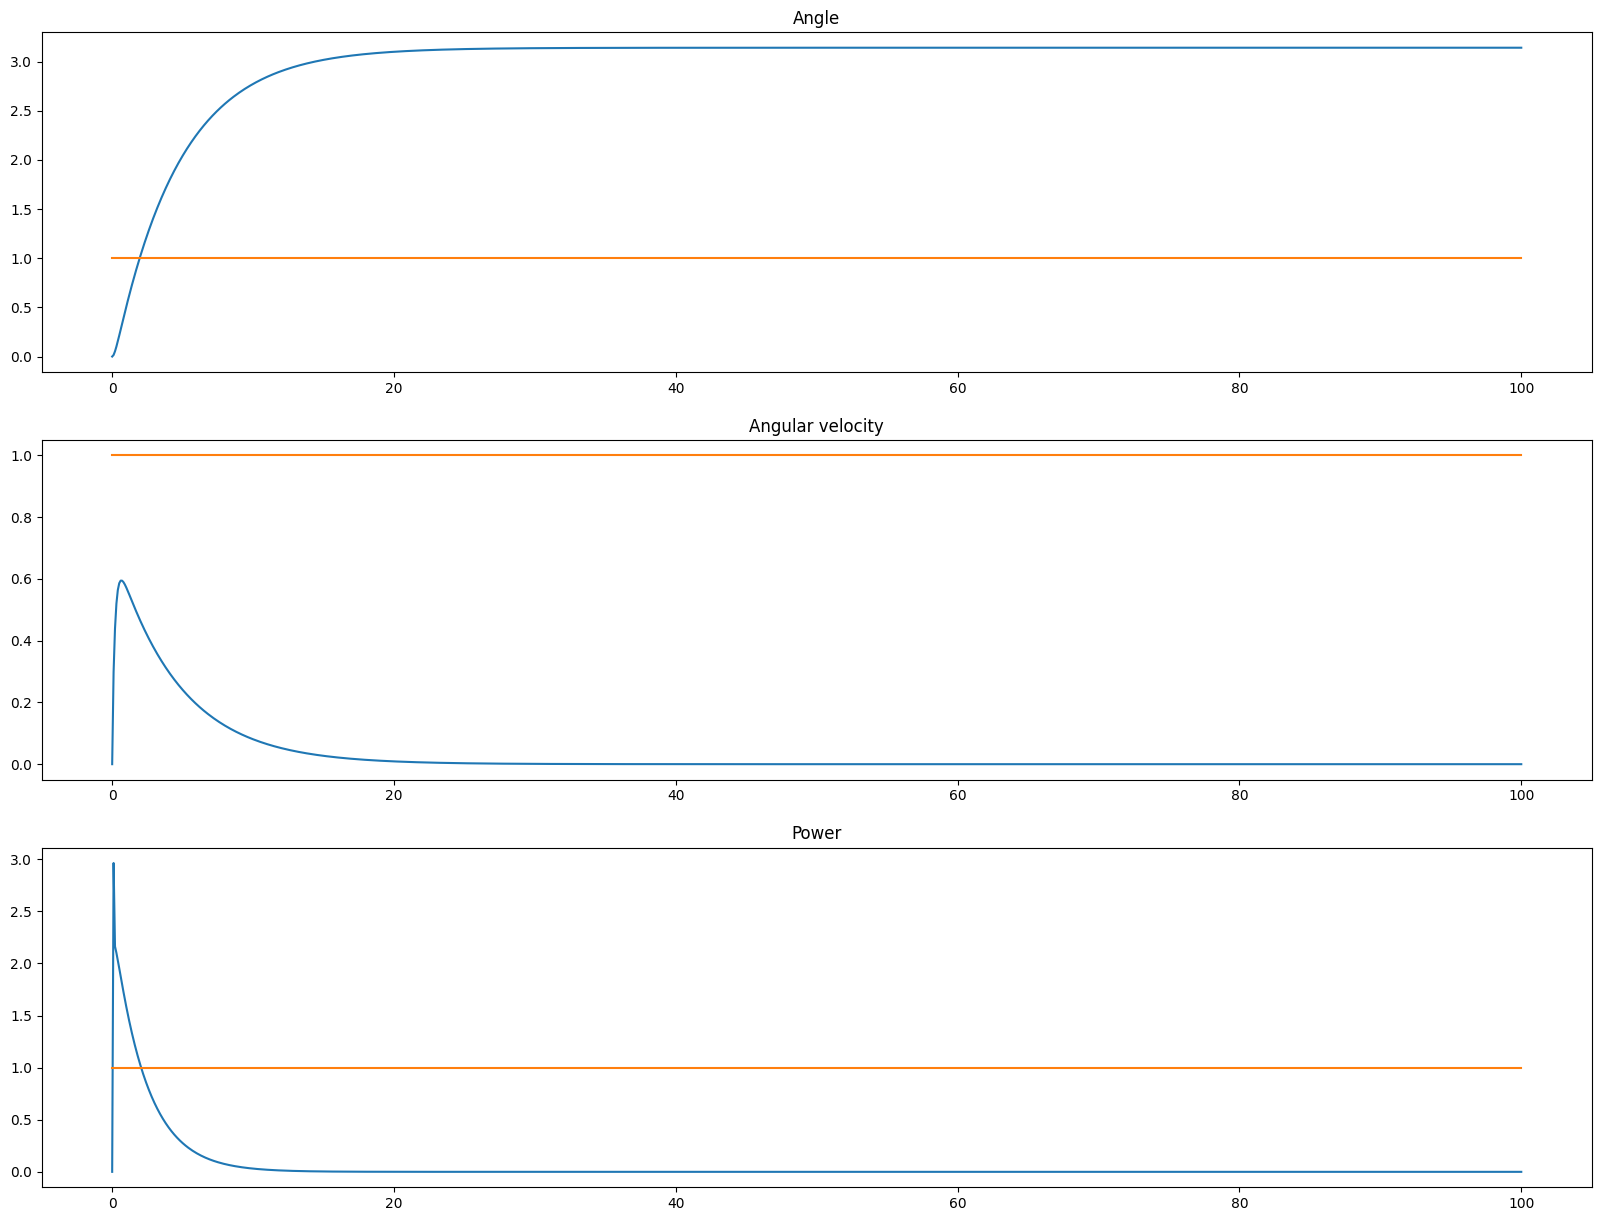

In [117]:
MONITOR_NAMES = ["MonAngle", "MonPower", "MonAngularVelocity"]
MONITOR_NAMES_TO_PLOT = ["MonAngle", "MonPower", "MonAngularVelocity"]

plt.rcParams["figure.figsize"] = (20,15)
plt.subplot(3, 1, 1)

signals = list(zip(X[:, 0][:, 0], X[:, 1][:, 0], X[:, 2][:, 0], U[:, 0], P[:, 0]))
monitors = []
results = []
for m in MONITOR_NAMES:
    monitor = moonlightScript.getMonitor(m)
    monitors.append(monitor)
    result = np.array(monitor.monitor(list(time),signals))
    results.append(result)

plt.title("Angle")
plt.plot(time, X[:, 1], label="Angle")
r = results[0]
plt.step(r[:,0],r[:,1], where='post', label="Angle monitor")

plt.subplot(3,1,3)
plt.title("Power")
plt.plot(time, P[:, 0], label="Power")
r = results[1]
plt.step(r[:,0],r[:,1], where='post', label="Power monitor")

plt.subplot(3,1,2)
plt.title("Angular velocity")
plt.plot(time, X[:, 2], label="Angular velocity")
r = results[2]
plt.step(r[:,0],r[:,1], where='post', label="Angular velocity monitor")


print("Test passed" if is_test_passed(results) else "Test not passed")